In [139]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve

Используя явную и неявную конечно-разностные схемы, а также схему Кранка - Николсона, решить начально-краевую задачу для дифференциального уравнения параболического типа. Осуществить реализацию трех вариантов аппроксимации граничных условий, содержащих производные: двухточечная аппроксимация с первым порядком, трехточечная аппроксимация со вторым порядком, двухточечная аппроксимация со вторым порядком. В различные моменты времени вычислить погрешность численного решения путем сравнения результатов с приведенным в задании аналитическим решением $U(x,t)$. Исследовать зависимость погрешности от сеточных параметров $\tau, h$.

$\frac{\partial u}{\partial t} = a\frac{\partial^2 u}{\partial x^2} + cu, a>0, c<0$

$u_x(0,t)=exp((c-a)t)$,

$u(\frac{\pi}{2},t) = exp((c-a)t)$,

$u(x,0)=\sin{x}$

Аналитическое решение: $U(x,t)=exp((c-a)t)\sin{x}$

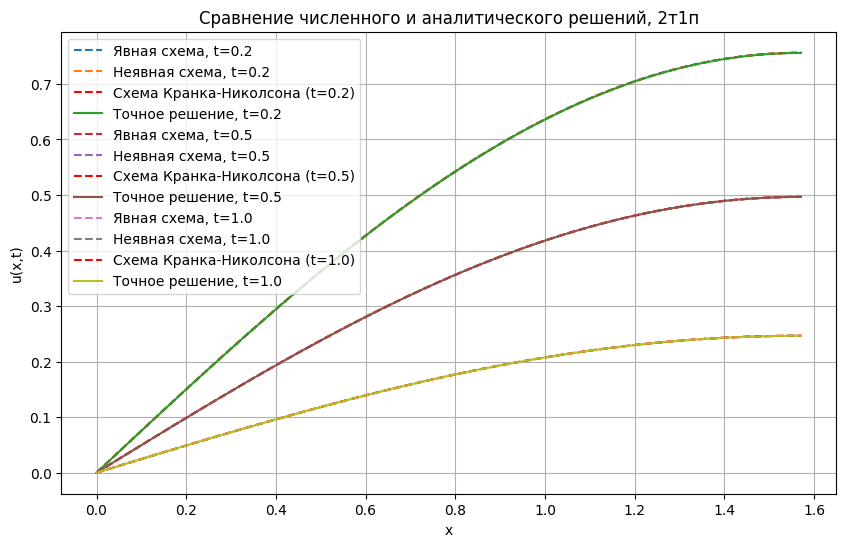

In [140]:
def decompose_to_LU(a):
    # create emtpy LU-matrix
    lu_matrix = np.matrix(np.zeros([a.shape[0], a.shape[1]]))
    n = a.shape[0]

    for k in range(n):
        # вычисляем остаточные элементы к-ой строки
        for j in range(k, n):
            lu_matrix[k, j] = a[k, j] - lu_matrix[k, :k] * lu_matrix[:k, j]
        # вычисляем остаточные элементы к-ого столбца
        for i in range(k + 1, n):
            lu_matrix[i, k] = (a[i, k] - lu_matrix[i, : k] * lu_matrix[: k, k]) / lu_matrix[k, k]

    return lu_matrix

def solve_LU(lu_matrix, b):
    # get supporting vector y
    y = np.matrix(np.zeros([lu_matrix.shape[0], 1]))
    for i in range(y.shape[0]):
        y[i, 0] = b[i] - lu_matrix[i, :i] * y[:i]

    # получаем вектор ответов
    x = np.matrix(np.zeros([lu_matrix.shape[0], 1]))
    for i in range(1, x.shape[0] + 1):
        x[-i, 0] = (y[-i] - lu_matrix[-i, -i:] * x[-i:, 0] )/ lu_matrix[-i, -i]

    return x

# Параметры
a = 0.4
b = 0.0
c = -1.0
L = np.pi / 2  # длина области
T = 1.0        # конечное время
sigma = 0.4    # число Куранта (должно быть < 0.5)
n = 100         # количество шагов пространственной сетки

# Пространственная и временная сетки
dx = L / (n - 1)
dt = sigma * dx**2 / a
nt = int(T / dt) + 1  # количество шагов по времени

# Сетка по x
x = np.linspace(0, L, n)
t = np.linspace(0, T, nt)

# Начальное условие
def initial_condition(x):
    return np.sin(x)

# Функция для решения задачи
def solve_parabolic_eq(a, c, dx, dt, nt, n, sigma, bnd=1):
    u = np.sin(x)
    u_new = np.zeros(n)  
    for k in range(0, nt-1):        
        # Аппроксимация внутренней области
        for i in range(1, n-1):
            u_new[i] = u[i] + dt * (a * (u[i+1] - 2*u[i] + u[i-1]) / dx**2 + c * u[i])
        
        # Аппроксимация граничных условий
        if bnd == 1:
            u_new[0] = u[1] - dx * np.exp((c-a) * t[k+1])  # u_x(0,t) = exp((c-a)t)
        elif bnd == 2:
            u_new[0] = u[2] - 2*dx * np.exp((c-a) * t[k+1])
        elif bnd == 3:
            u_new[0] = (u[2] - 4*u[1] + 2*dx * np.exp((c-a) * t[k+1])) * (-1/3)
        
        u_new[-1] = np.exp((c-a) * t[k+1])             # u(pi/2,t) = exp((c-a)t)
        
        u[:] = u_new
    
    return u

# Трёхточечная аппроксимация второго порядка для левой границы
def boundary_left_second_order_implicit(u):
    return (3*u[0] + u[2] + np.exp((c-a)*t*dt)*2*dx)/4

# Правое граничное условие: точное значение
def boundary_right_exact(c, a, t, dt):
    return np.exp((c - a) * t * dt)

# Трехточечная аппроксимация со вторым порядком
def second_order_three_point_boundary_conditions(u):
    return (u[0] + u[2]) / 2 - (dx**2 / 2) * (u[2] - 2*u[1] + u[0])  # u(0,t)

def ux0(t, c, a):
    return np.exp((c-a) * t) * dt

def uL(t, c, a):
    return np.exp((c-a) * t)

def implicit_scheme(n, nt, sigma, x, t, a, bnd=1):
    u = np.zeros((nt, n))
    u[0, :] = np.array([initial_condition(xi) for xi in x])

    A = np.zeros((n-2, n-2))
    for i in range(n-2):
        A[i, i] = 1 + 2 * sigma - c*dt
        if i > 0:
            A[i, i-1] = -sigma
        if i < n-3:
            A[i, i+1] = -sigma

    for n in range(0, nt-1):
        # Применяем апроксимацию
        b = u[n, 1:-1].copy()
        b[0] += sigma * (3*u[n+1, 0] + u[n+1, 2] + 2*dx * ux0(t[n+1], c, a))/4
        b[-1] += sigma * uL(t[n+1], c, a)
        u[n+1, 1:-1] = solve(A, b)
        if bnd == 1:
            u[n+1, 0] = u[n+1, 1] - dx * np.exp((c - a) * t[n+1])
        elif bnd == 2:
            u[n+1, 0] = u[n+1, 2] - 2*dx * np.exp((c - a) * t[n+1])
        elif bnd == 3:
            u[n+1, 0] = (u[n+1, 2] - 4*u[n+1, 1] + 2*dx * np.exp((c - a) * t[n+1])) * (-1/3)
        u[n+1, -1] = uL(t[n+1], c, a)
    return u


def crank_nicolson(n, nt, sigma, x, t, a, c, dx, dt): 
    # Инициализация массива решения
    u = np.zeros((nt, n))
    u[0, :] = np.array([np.sin(xi) for xi in x])

    # Матрицы для схемы Кранка-Николсона
    A = np.zeros((n-2, n-2))
    B = np.zeros((n-2, n-2))

    for i in range(n-2):
        A[i, i] = 1 + sigma + c * dt / 2
        B[i, i] = 1 - sigma - c * dt / 2

        if i > 0:
            A[i, i-1] = -sigma / 2
            B[i, i-1] = sigma / 2

        if i < n-3:
            A[i, i+1] = -sigma / 2
            B[i, i+1] = sigma / 2

    # Основной временной цикл
    for k in range(0, nt-1):
        # Формируем правую часть
        b = B @ u[k, 1:-1]

        # Учет граничных условий
        b[0] += sigma / 2 * (ux0(t[k+1], c, a) + ux0(t[k], c, a))
        b[-1] += sigma / 2 * (uL(t[k+1], c, a) + uL(t[k], c, a))

        # Решаем систему A * u_next = b
        u_next = solve(A, b)

        # Обновляем значения в массиве решения
        u[k+1, 1:-1] = u_next.copy()
        u[k+1, 0] = u[k+1, 1] - dx * np.exp((c - a) * t[k+1])  # Левая граница
        u[k+1, -1] = np.exp((c - a) * t[k+1])  # Правая граница

    return u

# Решение на разные моменты времени
times = [0.2, 0.5, 1.0]
solutions = {}
solutions2 = {}
solutions3 = {}
steps = [np.argmin(np.abs(t - tp)) for tp in times]


for t_val in times:
    nt_current = int(t_val / dt)  # количество шагов по времени для текущего t
    u_sol = solve_parabolic_eq(a, c, dx, dt, nt_current, n, sigma)
    solutions[t_val] = u_sol 
    u_sol2 = solve_parabolic_eq(a, c, dx, dt, nt_current, n, sigma, bnd=2)
    solutions2[t_val] = u_sol2
    u_sol3 = solve_parabolic_eq(a, c, dx, dt, nt_current, n, sigma, bnd=3)
    solutions3[t_val] = u_sol3  

u_sol_imp = implicit_scheme(n, nt, sigma, x, t, a)
u_sol_imp2 = implicit_scheme(n, nt, sigma, x, t, a, bnd=2)
u_sol_imp3 = implicit_scheme(n, nt, sigma, x, t, a, bnd=3)
u_crank_nicolson = crank_nicolson(n, nt, sigma, x, t, a, c, dx, dt)

# Функция аналитического решения
def analytical_solution(x, t, a, c):
    return np.exp((c - a) * t) * np.sin(x)

# Визуализация численного и аналитического решений
plt.figure(figsize=(10, 6))
for step, t_val in zip(steps, times):
    # Численное решение
    plt.plot(x, solutions[t_val], label=f'Явная схема, t={t_val}', linestyle='--')
    plt.plot(x, u_sol_imp[step, :], label=f'Неявная схема, t={t_val}', linestyle='--')
    plt.plot(x, 0.5*u_sol_imp[step, :] + 0.5*solutions[t_val], label=f'Схема Кранка-Николсона (t={t_val})', linestyle='--', color='r')
    # Аналитическое решение
    u_analytic = analytical_solution(x, t_val, a, c)
    plt.plot(x, u_analytic, label=f'Точное решение, t={t_val}')

plt.title('Сравнение численного и аналитического решений, 2т1п')
plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.legend()
plt.grid(True)
plt.show()

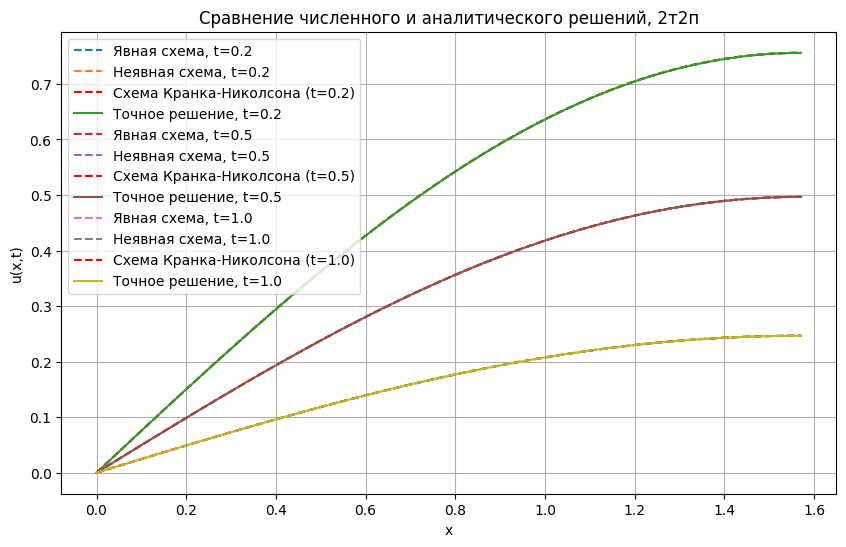

In [141]:
plt.figure(figsize=(10, 6))
for step, t_val in zip(steps, times):
    # Численное решение
    plt.plot(x, solutions2[t_val], label=f'Явная схема, t={t_val}', linestyle='--')
    plt.plot(x, u_sol_imp2[step, :], label=f'Неявная схема, t={t_val}', linestyle='--')
    plt.plot(x, 0.5*u_sol_imp2[step, :] + 0.5*solutions2[t_val], label=f'Схема Кранка-Николсона (t={t_val})', linestyle='--', color='r')
    # Аналитическое решение
    u_analytic = analytical_solution(x, t_val, a, c)
    plt.plot(x, u_analytic, label=f'Точное решение, t={t_val}')

plt.title('Сравнение численного и аналитического решений, 2т2п')
plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.legend()
plt.grid(True)
plt.show()

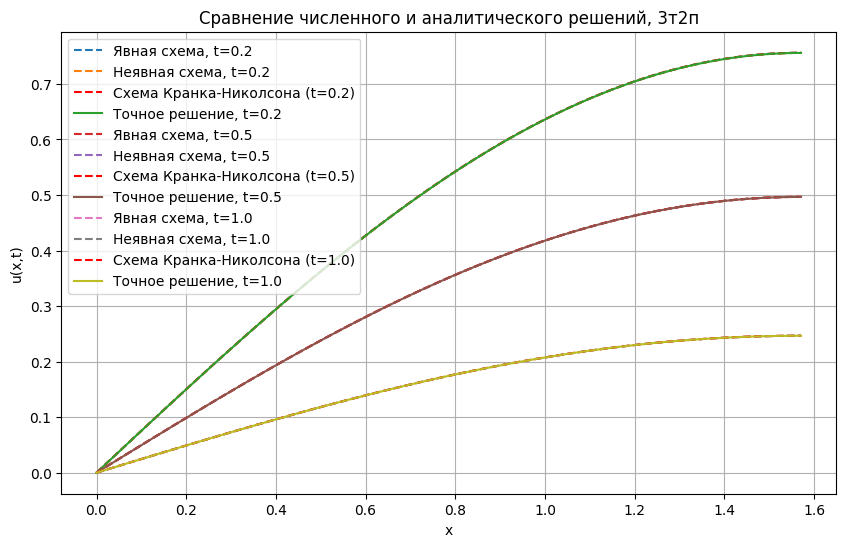

In [142]:
plt.figure(figsize=(10, 6))
for step, t_val in zip(steps, times):
    # Численное решение
    plt.plot(x, solutions3[t_val], label=f'Явная схема, t={t_val}', linestyle='--')
    plt.plot(x, u_sol_imp3[step, :], label=f'Неявная схема, t={t_val}', linestyle='--')
    plt.plot(x, 0.5*u_sol_imp3[step, :] + 0.5*solutions3[t_val], label=f'Схема Кранка-Николсона (t={t_val})', linestyle='--', color='r')
    # Аналитическое решение
    u_analytic = analytical_solution(x, t_val, a, c)
    plt.plot(x, u_analytic, label=f'Точное решение, t={t_val}')

plt.title('Сравнение численного и аналитического решений, 3т2п')
plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.legend()
plt.grid(True)
plt.show()

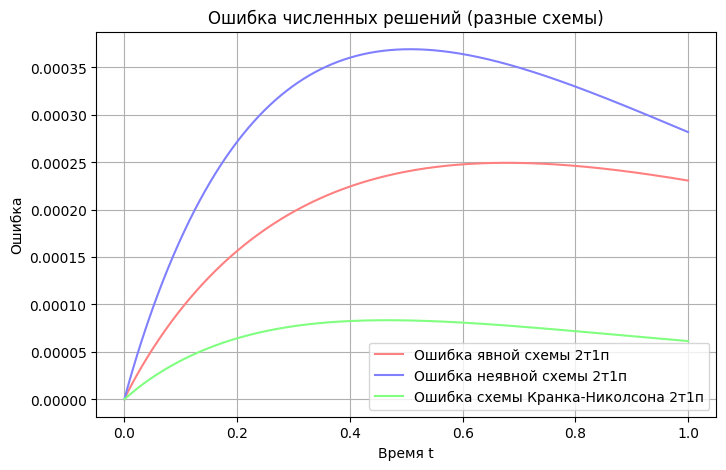

In [145]:
# Вычисление ошибок для всех схем
def solve_explicit(a, c, dx, dt, nt, n, x, t, bnd=1):
    u = np.zeros((nt, n)) # Инициализация двумерного массива
    u[0, :] = np.sin(x)  # Начальное условие

    for k in range(nt - 1):
        u_new = u[k, :].copy()  # Создаем копию предыдущего шага для обновления

        # Аппроксимация внутренней области
        for i in range(1, n - 1):
            u_new[i] = u[k, i] + dt * (a * (u[k, i + 1] - 2 * u[k, i] + u[k, i - 1]) / dx**2 + c * u[k, i])

        # Аппроксимация граничных условий
        if bnd == 1:
            u_new[0] = u[k, 1] - dx * np.exp((c - a) * t[k])  # u_x(0,t) = exp((c-a)t)
        elif bnd == 2:
            u_new[0] = u[k, 2] - 2*dx * np.exp((c - a) * t[k])
        elif bnd == 3:
            u_new[0] = (u[k, 2] - 4*u[k, 1] + 2*dx * np.exp((c - a) * t[k])) * (-1/3)
        u_new[-1] = np.exp((c - a) * t[k + 1])  # u(pi/2,t) = exp((c-a)t)

        u[k + 1, :] = u_new  # Записываем обновленное решение
    return u

u_explicit = solve_explicit(a, c, dx, dt, nt, n, x, t)
u_explicit2 = solve_explicit(a, c, dx, dt, nt, n, x, t, bnd=2)
u_explicit3 = solve_explicit(a, c, dx, dt, nt, n, x, t, bnd=3)
u_analytical = np.array([[analytical_solution(xi, t_val, a, c) for xi in x] for t_val in t])
u_crank_n = 0.5*u_explicit + 0.5*u_sol_imp
u_crank_n2 = 0.5*u_explicit2 + 0.5*u_sol_imp2
u_crank_n3 = 0.5*u_explicit3 + 0.5*u_sol_imp3
error_explicit = np.sqrt(np.sum((u_explicit - u_analytical)**2, axis=1))
error_implicit = np.sqrt(np.sum((u_sol_imp - u_analytical)**2, axis=1))
error_crank_nicolson = np.sqrt(np.sum((u_crank_n - u_analytical)**2, axis=1))
error_explicit2 = np.sqrt(np.sum((u_explicit2 - u_analytical)**2, axis=1))
error_implicit2 = np.sqrt(np.sum((u_sol_imp2 - u_analytical)**2, axis=1))
error_crank_nicolson2 = np.sqrt(np.sum((u_crank_n2 - u_analytical)**2, axis=1))
error_explicit3 = np.sqrt(np.sum((u_explicit3 - u_analytical)**2, axis=1))
error_implicit3 = np.sqrt(np.sum((u_sol_imp3 - u_analytical)**2, axis=1))
error_crank_nicolson3 = np.sqrt(np.sum((u_crank_n3 - u_analytical)**2, axis=1))

# Визуализация ошибок
red_shades = [(1, 0.5, 0.5, 1), (1, 0.2, 0.2, 1), (0.8, 0, 0, 1)]
blue_shades = [(0.5, 0.5, 1, 1), (0.2, 0.2, 1, 1), (0, 0, 0.8, 1)]
green_shades = [(0.5, 1, 0.5, 1), (0.2, 1, 0.2, 1), (0, 0.8, 0, 1)]

plt.figure(figsize=(8, 5))
plt.plot(t, error_explicit, label='Ошибка явной схемы 2т1п', color=red_shades[0])
plt.plot(t, error_implicit, label='Ошибка неявной схемы 2т1п', color=blue_shades[0])
plt.plot(t, error_crank_nicolson, label='Ошибка схемы Кранка-Николсона 2т1п', color=green_shades[0])
plt.xlabel('Время t')
plt.ylabel('Ошибка')
plt.legend()
plt.title('Ошибка численных решений (разные схемы)')
plt.grid(True)
plt.show()

# Вывод максимальных ошибок для всех схем
#print(f"Максимальная ошибка (явная схема): {np.max(error_explicit)}")
#print(f"Максимальная ошибка (неявная схема): {np.max(error_implicit)}")
#print(f"Максимальная ошибка (схема Кранка-Николсона): {np.max(error_crank_nicolson)}")

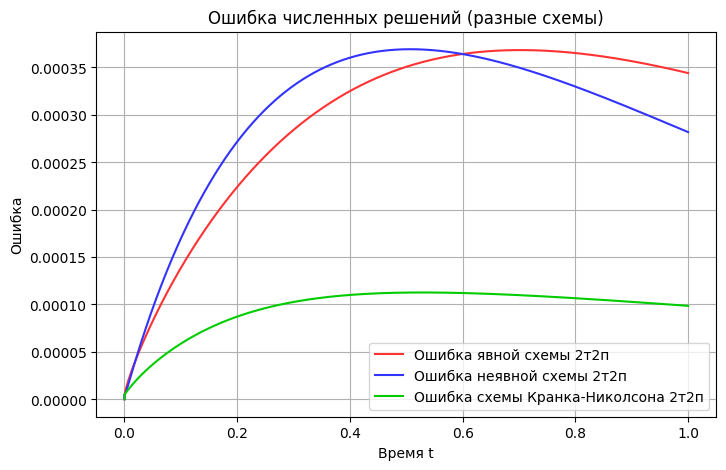

In [146]:
plt.figure(figsize=(8, 5))
plt.plot(t, error_explicit2, label='Ошибка явной схемы 2т2п', color=red_shades[1])
plt.plot(t, error_implicit2, label='Ошибка неявной схемы 2т2п', color=blue_shades[1])
plt.plot(t, error_crank_nicolson2, label='Ошибка схемы Кранка-Николсона 2т2п', color=green_shades[2])
plt.xlabel('Время t')
plt.ylabel('Ошибка')
plt.legend()
plt.title('Ошибка численных решений (разные схемы)')
plt.grid(True)
plt.show()

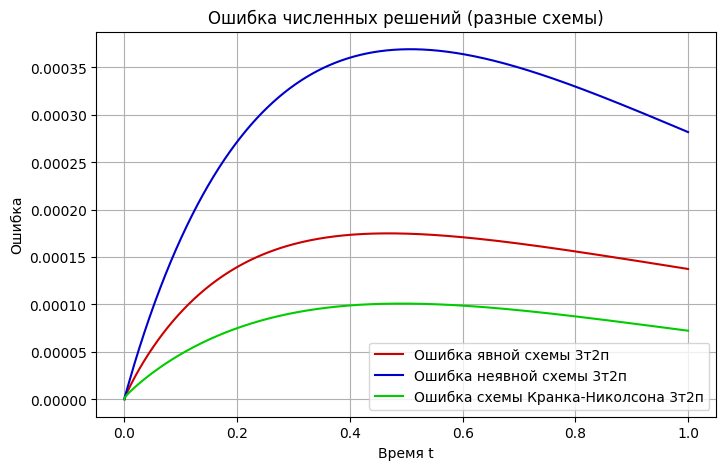

In [147]:
plt.figure(figsize=(8, 5))
plt.plot(t, error_explicit3, label='Ошибка явной схемы 3т2п', color=red_shades[2])
plt.plot(t, error_implicit3, label='Ошибка неявной схемы 3т2п', color=blue_shades[2])
plt.plot(t, error_crank_nicolson3, label='Ошибка схемы Кранка-Николсона 3т2п', color=green_shades[2])
plt.xlabel('Время t')
plt.ylabel('Ошибка')
plt.legend()
plt.title('Ошибка численных решений (разные схемы)')
plt.grid(True)
plt.show()